## Boston Airbnb

### Business Understanding
Airbnb has given the opportunity for millions of people to connect all over the world. One of the core values of Airbnb is to make people feel that they could "belong anywhere." Airbnb gives people the ability to travel all over the world and bring people from different places, cultures, and backgrounds together so that they can experience the world in a place that isn't necessary their home, but feels like home.

The motivation behind this project is to create data-driven solutions to solve problems of Airbnb travelers and hosts in Boston:
* What time of the year are Airbnb prices in Boston the highest and lowest?
* Which neighborhoods in Boston are more expensive to rent than others?
* Can we predict prices based on the time of year and features of the Airbnb?

### Data Understanding
Kaggle Link: https://www.kaggle.com/airbnb/boston

Project Rubric: https://review.udacity.com/#!/rubrics/1507/view

Three CSVs:
* Calendar: listing id, price, and availability
* Listings: listing id, descriptions, average review score
* Reviews: listing id, comment reviews by reviewers

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score, mean_squared_error

import xgboost
from xgboost import XGBRegressor


%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

### Data Preparing
* Cleaning, Pre-processing

In [2]:
calendar = pd.read_csv('data/calendar.csv')
listings = pd.read_csv('data/listings.csv')
reviews = pd.read_csv('data/reviews.csv')

In [3]:
calendar.shape

(1308890, 4)

In [4]:
calendar.head()

,listing_id,date,available,price
0,12147973,2017-09-05,f,NaN
1,12147973,2017-09-04,f,NaN
2,12147973,2017-09-03,f,NaN
3,12147973,2017-09-02,f,NaN
4,12147973,2017-09-01,f,NaN


In [5]:
len(set(calendar['listing_id']))

3585

In [6]:
listings.shape

(3585, 95)

In [7]:
listings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,12147973,https://www.airbnb.com/rooms/12147973,20160906204935,2016-09-07,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...",none,"Roslindale is quiet, convenient and friendly. ...",...,NaN,f,NaN,NaN,f,moderate,f,f,1,NaN
1,3075044,https://www.airbnb.com/rooms/3075044,20160906204935,2016-09-07,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,none,"The room is in Roslindale, a diverse and prima...",...,9.0,f,NaN,NaN,t,moderate,f,f,1,1.30
2,6976,https://www.airbnb.com/rooms/6976,20160906204935,2016-09-07,Mexican Folk Art Haven in Boston,"Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...",none,The LOCATION: Roslindale is a safe and diverse...,...,10.0,f,NaN,NaN,f,moderate,t,f,1,0.47
3,1436513,https://www.airbnb.com/rooms/1436513,20160906204935,2016-09-07,Spacious Sunny Bedroom Suite in Historic Home,Come experience the comforts of home away from...,Most places you find in Boston are small howev...,Come experience the comforts of home away from...,none,Roslindale is a lovely little neighborhood loc...,...,10.0,f,NaN,NaN,f,moderate,f,f,1,1.00
4,7651065,https://www.airbnb.com/rooms/7651065,20160906204935,2016-09-07,Come Home to Boston,"My comfy, clean and relaxing home is one block...","Clean, attractive, private room, one block fro...","My comfy, clean and relaxing home is one block...",none,"I love the proximity to downtown, the neighbor...",...,10.0,f,NaN,NaN,f,flexible,f,f,1,2.25


In [8]:
reviews.shape

(68275, 6)

In [9]:
reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,1178162,4724140,2013-05-21,4298113,Olivier,My stay at islam's place was really cool! Good...
1,1178162,4869189,2013-05-29,6452964,Charlotte,Great location for both airport and city - gre...
2,1178162,5003196,2013-06-06,6449554,Sebastian,We really enjoyed our stay at Islams house. Fr...
3,1178162,5150351,2013-06-15,2215611,Marine,The room was nice and clean and so were the co...
4,1178162,5171140,2013-06-16,6848427,Andrew,Great location. Just 5 mins walk from the Airp...


### Data Cleaning

#### Calendar Dataset

In [10]:
calendar.sample(10)

,listing_id,date,available,price
125515,11553697,2016-10-20,f,NaN
430485,5834930,2017-03-11,t,$125.00
415401,12653367,2017-05-23,f,NaN
182840,13658697,2016-09-30,f,NaN
1089749,4934600,2017-07-27,t,$140.00
265966,971393,2017-01-02,t,$175.00
319378,8228903,2017-09-02,t,$198.00
586693,12233043,2017-03-12,f,NaN
982001,6300089,2017-02-14,t,$245.00
124059,8981656,2017-07-28,t,$99.00


In [11]:
calendar['available'].value_counts()

f    665853
t    643037
Name: available, dtype: int64

In [12]:
calendar = calendar[calendar['available'] == 't'] #rental is available
calendar['price'] = calendar['price'].str.replace('$', '') #remove $ sign
calendar['price'] = calendar['price'].str.replace(',', '') #remove commas
calendar['price'] = calendar['price'].astype(float) #convert string to float
calendar['date'] = pd.to_datetime(calendar['date']) #convert date to datetime
calendar['year'] = pd.DatetimeIndex(calendar['date']).year #grab the year
calendar['month'] = pd.DatetimeIndex(calendar['date']).month #grab the month

In [13]:
calendar.sample(5)

,listing_id,date,available,price,year,month
868981,10048789,2016-11-28,t,349.0,2016,11
629192,189965,2016-11-12,t,125.0,2016,11
31528,3997572,2017-04-02,t,85.0,2017,4
1059415,6626933,2017-01-08,t,75.0,2017,1
1269029,8034092,2016-11-20,t,30.0,2016,11


#### Listings Dataset

In [14]:
listings.shape

(3585, 95)

In [15]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3585 entries, 0 to 3584
Data columns (total 95 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3585 non-null   int64  
 1   listing_url                       3585 non-null   object 
 2   scrape_id                         3585 non-null   int64  
 3   last_scraped                      3585 non-null   object 
 4   name                              3585 non-null   object 
 5   summary                           3442 non-null   object 
 6   space                             2528 non-null   object 
 7   description                       3585 non-null   object 
 8   experiences_offered               3585 non-null   object 
 9   neighborhood_overview             2170 non-null   object 
 10  notes                             1610 non-null   object 
 11  transit                           2295 non-null   object 
 12  access

In [16]:
listings.sample(2)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
1710,12432535,https://www.airbnb.com/rooms/12432535,20160906204935,2016-09-07,Cozy 1BR w/ private deck in historic Charlestown!,Welcome to my apartment in Boston's historic C...,The apartment is a cozy one bedroom that can e...,Welcome to my apartment in Boston's historic C...,none,THE historic neighborhood in America's histori...,...,10.0,f,NaN,NaN,f,moderate,f,f,1,2.84
2372,7362715,https://www.airbnb.com/rooms/7362715,20160906204935,2016-09-07,Location! Spacious with patio,"Nice, cozy apartment, great living room with q...",You will have a spacious living room with a co...,"Nice, cozy apartment, great living room with q...",none,This is one of the most desirable neighborhood...,...,9.0,f,NaN,NaN,f,strict,f,f,2,0.26


In [17]:
listings['neighbourhood'].value_counts()

Allston-Brighton      364
Jamaica Plain         314
South End             298
Back Bay              291
Fenway/Kenmore        249
South Boston          216
Dorchester            195
Beacon Hill           174
North End             125
East Boston           117
Roxbury               116
Mission Hill          103
Charlestown            79
Chinatown              78
West End               68
Roslindale             50
West Roxbury           35
Theater District       33
Downtown Crossing      26
Hyde Park              25
Mattapan               20
Somerville             13
Financial District     13
Brookline               8
Downtown                8
Leather District        8
Cambridge               7
Chestnut Hill           4
Government Center       3
Harvard Square          2
Name: neighbourhood, dtype: int64

#### Dealing with Null Values (Resubmission)
* Here we extract the neighborhood and Airbnb id from the Listings dataframe to merge with calendar dataframe on the Airbnb id
* In the listings dataframe, there are 543 observations with missing neighbourhood values. With the highest average price is Harvard Square at 576.55 while the lowest average price is 73.57 at Hyde Park, it wouldn't make sense to perform imputation with the mean, median, or mode because the average price range of all the Airbnbs very much different depending on the neighborhood.. Imputing will reduce the variability and power of the features when doing predictive modeling in the next step.
* As a result, I decided to drop the observations with missing neighborhood values as to not reduce the variability of the feature. We do introduce bias into the model so we have to be wary of that.

In [47]:
neighborhood_listings[neighborhood_listings['neighbourhood'].isna()].shape

(543, 2)

In [18]:
neighborhood_listings = listings[['id','neighbourhood']]
neighborhood_calendar = calendar.merge(neighborhood_listings, left_on='listing_id', right_on='id')
neighborhood_calendar.dropna(inplace=True)
neighborhood_prices = neighborhood_calendar.groupby('neighbourhood')['price'].mean().sort_values(ascending=False)

print(neighborhood_prices)

neighbourhood
Harvard Square        576.558140
Financial District    441.700146
Chinatown             341.990203
Downtown Crossing     330.866325
Government Center     327.762457
West End              320.444520
Fenway/Kenmore        306.799834
Back Bay              286.039521
Leather District      284.532149
South Boston          250.847528
Beacon Hill           244.170634
South End             237.768543
North End             229.789114
Charlestown           220.056090
Cambridge             213.087600
Theater District      200.627595
Mission Hill          171.634085
Roxbury               163.847611
Jamaica Plain         158.740517
Downtown              151.604509
East Boston           147.689503
Allston-Brighton      135.948433
West Roxbury          126.005327
Brookline             119.763103
Dorchester             97.524291
Roslindale             95.783921
Somerville             91.749442
Mattapan               81.133937
Chestnut Hill          79.018009
Hyde Park              73.465

### Data Visualizations

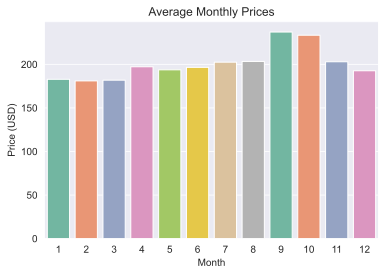

In [19]:
monthly_prices = calendar.groupby('month')['price'].mean()

sns.barplot(monthly_prices.index, monthly_prices.values, palette = 'Set2')
plt.title('Average Monthly Prices')
plt.xlabel('Month')
plt.ylabel('Price (USD)')
plt.show()

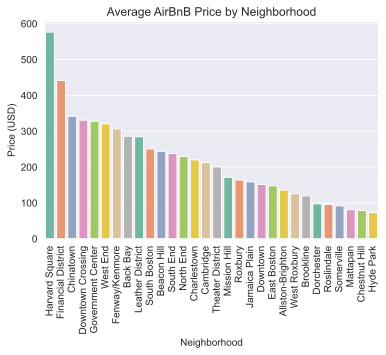

In [20]:
sns.barplot(neighborhood_prices.index, neighborhood_prices.values, palette = 'Set2')
plt.xticks(rotation=90)
plt.title('Average AirBnB Price by Neighborhood')
plt.xlabel('Neighborhood')
plt.ylabel('Price (USD)')
plt.show()

### Data Pre-Processing
Merge Calendar and Listings DataFrames on listing_id and id

#### Dealing with Categorical Variables
* I decided to encode the categorical variables year, month, and neighborhood to 1s and 0s using Pandas get_dummies function
* Encoding allows for easier interpretation of coefficients and an increase flexibility of influence from each category
* Also need to be wary that we do add alot of columns to the dataset

#### Choosing Which Columns to Drop (resubmission) 
* To format the input to the machine learning models, I dropped columns that wouldn't make sense to add to the model. These included the columns listing_id, date, available, year, month, id, and neighbourhood
* listing_id and id columns makes sense to drop because a powerful model will overfit to these columns resulting in strong evaluation scores on the training set but will perform poorly on new data (overfitting)
* available is dropped because the values are all the same and makes no sense to keep it
* date, year, and month are dropped because we already created the year and month encodings so we do not want to have repeated features in the final dataset
* neighborhood is dropped because we also already created neighborhood encodings so again we do not want repeated features

#### Choosing Which Columns to Keep
* The pre_process_df function takes in a list of columns from the listings dataframe to use as features for the ML model. 
* Based on initial intuition of what features I think would greatly influence the price, I began my investigation using the features accommodates, bathrooms, bedrooms, beds, review_scores_rating, and neighbourhoods.
* The function allows for flexibility, you can simply add or remove the feature from the list of columns the function takes in as input.

In [21]:
def pre_process_df(columns):
    '''
    Returns the merged DataFrame from the listing and calendar datasets.
    
    Input: 
    * columns: select features from listing dataframe.
    
    Currently only pre-processes year, month, neighbourhood columns. 
    '''
    feature_df = listings[columns]
    merge_df = calendar.merge(feature_df, left_on='listing_id', right_on='id')

    merge_df.dropna(inplace=True) #drop missing values

    merge_df = merge_df.join(pd.get_dummies(merge_df['year'], prefix='year'))
    merge_df = merge_df.join(pd.get_dummies(merge_df['month'], prefix='month'))
    merge_df = merge_df.join(pd.get_dummies(merge_df['neighbourhood'], prefix='neighborhood'))

    drop_cols = ['listing_id', 'date','available','year','month','id', 'neighbourhood']
    merge_df.drop(drop_cols, axis=1, inplace=True) #See explanation above
     
    return merge_df

In [22]:
columns = ['id','neighbourhood','accommodates', 'bathrooms', 'bedrooms','beds', 'review_scores_rating']
final_df = pre_process_df(columns)

In [23]:
final_df.shape

(432617, 49)

### Splitting Dataset into Training and Testing Sets

In [24]:
X = final_df.drop('price', axis=1)
y = final_df['price']

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=24)

### Models and Evaluation
Regression Models
* Linear Regression
* Ridge Regression
* XGBoost Regressor

Evaluation Metrics
* R-2 Score
* Mean Squared Error

Linear Regression will be used as the baseline model to compare against the Ridge Regression and XGBoost Regressor. I would expect the XGBoost Regressor to perform the best based on the R-2 score and MSE evaluation metrics because of its' strong predictive power compared to the linear models.

Further research could be done in this analysis. For example, we could use grid search to tune the hyperparameters for the models to produce better results. But in this case, I wanted to focus more on presentation and the ability to communicate results to non-technical audiences through a blog post.

In [26]:
lr = LinearRegression(normalize=True)
lr.fit(X_train, y_train)
y_preds = lr.predict(X_test)

print("Linear Regression metrics")
print("r2: ", r2_score(y_test, y_preds))
print("mse: ", mean_squared_error(y_test, y_preds))

Linear Regression metrics
r2:  0.5382059020665242
mse:  11542.053012712167


In [27]:
ridge= Ridge(normalize=True)
ridge.fit(X_train, y_train)
y_preds = ridge.predict(X_test)

print('Ridge metrics')
print("r2: ", r2_score(y_test, y_preds))
print("mse: ", mean_squared_error(y_test, y_preds))

Ridge metrics
r2:  0.45953247096249894
mse:  13508.41186519241


In [28]:
xgb = XGBRegressor()
xgb.fit(X_train, y_train)
y_preds = xgb.predict(X_test)

print('Xgboost metrics')
print("r2: ", r2_score(y_test, y_preds))
print("mse: ", mean_squared_error(y_test, y_preds))

Xgboost metrics
r2:  0.8385258303689882
mse:  4035.8753704411747


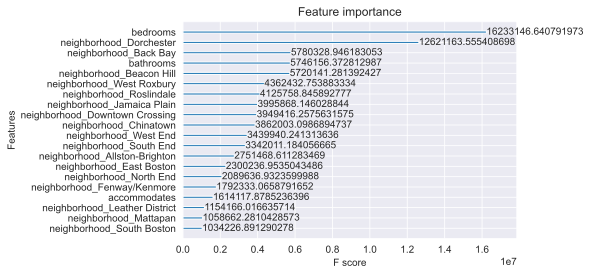

In [29]:
xgboost.plot_importance(xgb, importance_type='gain', max_num_features=20)
plt.show()

Top 5 features influencing the price based on information gain:
* Number of bedrooms
* Neighborhood in Dorchester
* Neighborhood in Back Bay
* Number of bathrooms
* Neighborhood in Beacon Hill

### Deployment
* Code deployed on GitHub
* Blog written on portfolio website